In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table, weekday_time_series
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import plotly
import torch
import gpytorch

In [2]:
eg = weekday_time_series(sensor_id='eg_30T')

In [3]:
eg['kw'] = round(eg['kw'], 2)

In [5]:
px.line(
    x=eg.index, y=eg.kw, 
    title='entsorgung_5T',
    labels={
        'x': 'Time',
        'y': 'kW'
    },
    markers=False)

In [6]:
eg.index.shape

(240,)

In [7]:
time_int_range = np.arange(0, 240*5, 5)
eg['t'] = time_int_range

#entsorgung_final = pd.DataFrame(data=entsorgung['kw'], index=entsorgung['t'])
#entsorgung_final.reset_index(inplace=True)

X = eg['t'].values
y = eg['kw'].values
n = len(X)
prop_train = 0.8
n_train = round(prop_train * n)

# Training
X_train = torch.from_numpy(X[:n_train]).to(torch.float64)
y_train = torch.from_numpy(y[:n_train]).to(torch.float64)

# Testing
#X_test = torch.from_numpy(y[n_train:]).to(torch.float64)
X_test = torch.from_numpy(X).to(torch.float64)
y_test = torch.from_numpy(y[n_train:]).to(torch.float64)

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

plt.figure(figsize=(16, 6))
#plt.plot(X_train.numpy(), y_train.numpy())
#plt.plot(X_test.numpy(), y_test.numpy())

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

In [8]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(110, 130) ## short term

        seasonal_periodic_short = gpytorch.kernels.PeriodicKernel(
            period_length_constraint=period_constraint_short
        )

        period_constraint_long = gpytorch.constraints.Interval(225, 245) ## long term

        seasonal_periodic_long = gpytorch.kernels.PeriodicKernel(
            period_length_constraint=period_constraint_long
        )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.RQKernel()
        local_variation.alpha = 1


        self.covar_module = seasonal_periodic_short + seasonal_periodic_long + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [11]:
## v2 - adding scaling parameters ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(110, 130) ## short term

        seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        period_constraint_long = gpytorch.constraints.Interval(225, 245) ## long term

        seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_long
                )
            )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        local_variation.alpha = 1


        self.covar_module = seasonal_periodic_short + seasonal_periodic_long + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [9]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 75

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood=likelihood, model=model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()

    print('Iter {} , Loss = {} , Noise = {}'.format(
        i+1, loss, model.likelihood.noise.item() 
    ))

    optimizer.step()

model.eval()
likelihood.eval()

Iter 1 , Loss = 1.2951647275207614 , Noise = 0.6932471990585327
Iter 2 , Loss = 1.2777899536484916 , Noise = 0.6444966793060303
Iter 3 , Loss = 1.2612018506730875 , Noise = 0.5982586741447449
Iter 4 , Loss = 1.2448674148793877 , Noise = 0.5545298457145691
Iter 5 , Loss = 1.2284073216947242 , Noise = 0.5132927894592285
Iter 6 , Loss = 1.211865816917432 , Noise = 0.47451502084732056
Iter 7 , Loss = 1.1952805147089631 , Noise = 0.4381507635116577
Iter 8 , Loss = 1.1785949919267529 , Noise = 0.40414151549339294
Iter 9 , Loss = 1.1616526647779686 , Noise = 0.3724172115325928
Iter 10 , Loss = 1.144232733024005 , Noise = 0.3428966701030731
Iter 11 , Loss = 1.1261186129912257 , Noise = 0.3154890239238739
Iter 12 , Loss = 1.1071380904408086 , Noise = 0.2900952100753784
Iter 13 , Loss = 1.087159825199027 , Noise = 0.26661038398742676
Iter 14 , Loss = 1.0660775842710593 , Noise = 0.24492575228214264
Iter 15 , Loss = 1.043800659859248 , Noise = 0.22493082284927368
Iter 16 , Loss = 1.02025127716495

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

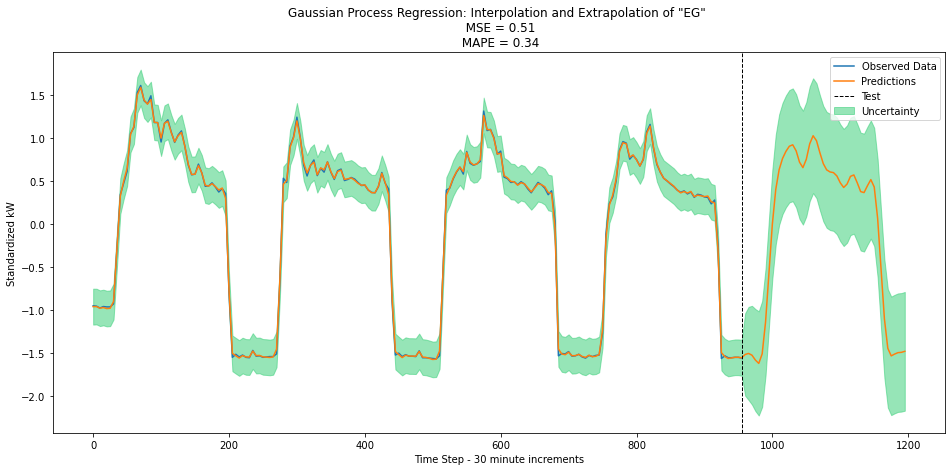

In [12]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_preds = likelihood(model(X_test))

    test_preds = observed_preds.mean[n_train:]
    mse = mean_squared_error(y_test.numpy(), test_preds.numpy())
    mape = mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

    f, ax = plt.subplots(figsize=(16, 7))
    lower, upper = observed_preds.confidence_region()
    ax.plot(X_train.numpy(), y_train.numpy())
    ax.plot(X_test.numpy(), observed_preds.mean.numpy())
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    plt.axvline(x=955, linestyle='--', color='black', lw=1)
    ax.legend(['Observed Data', 'Predictions', 'Test', 'Uncertainty'])
    plt.xlabel('Time Step - 30 minute increments')
    plt.ylabel('Standardized kW')
    plt.title('Gaussian Process Regression: Interpolation and Extrapolation of "EG" \n  MSE = {} \n MAPE = {}'.
    format(round(mse, 2), round(mape, 2)))
    plt.show()

In [11]:
observed_preds.mean

tensor([-9.5705e-01, -9.5623e-01, -9.7547e-01, -9.6716e-01, -9.7946e-01,
        -9.7635e-01, -8.9920e-01, -2.9528e-01,  3.2746e-01,  4.9999e-01,
         6.5129e-01,  1.0414e+00,  1.1373e+00,  1.5018e+00,  1.5881e+00,
         1.4407e+00,  1.3943e+00,  1.4473e+00,  1.1836e+00,  1.1788e+00,
         9.9901e-01,  1.1720e+00,  1.1950e+00,  1.0632e+00,  9.5644e-01,
         1.0262e+00,  1.0654e+00,  9.0483e-01,  6.9761e-01,  5.7766e-01,
         5.7980e-01,  6.8067e-01,  5.9557e-01,  4.5269e-01,  4.4239e-01,
         4.7022e-01,  4.3720e-01,  3.9698e-01,  4.1952e-01,  3.0097e-01,
        -7.6600e-01, -1.4995e+00, -1.5274e+00, -1.5536e+00, -1.5250e+00,
        -1.5411e+00, -1.5428e+00, -1.4729e+00, -1.5256e+00, -1.5236e+00,
        -1.5403e+00, -1.5430e+00, -1.5472e+00, -1.5402e+00, -1.4527e+00,
        -6.2918e-01,  4.6307e-01,  5.1014e-01,  8.9392e-01,  1.0055e+00,
         1.1996e+00,  9.9447e-01,  7.1350e-01,  5.9571e-01,  6.8304e-01,
         7.2089e-01,  5.7378e-01,  6.5412e-01,  6.3